# Classification of synapses

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

scifAI: An explainable AI python framework for the analysis of multi-channel imaging flow cytometry data


We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

This notebook provides an example for deep learning methods

here we import a series of needed modules. 

In [1]:
import scifAI
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from IPython.core.debugger import Tracer
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

In [2]:
from scifAI.dl.utils import calculate_weights, train_validation_test_split, get_statistics
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.custom_transforms import ShuffleChannel
from scifAI.dl.models import PretrainedModel, resnet18

In [3]:
from iflai.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [4]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(y_true, y_pred, plot = True ): 
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    

now lets calculate the metadata:

In [5]:
%%time

metadata = pd.read_csv("/pstore/data/DS4/synapse_data_features/metadata_subset.csv.gz")

CPU times: user 1.94 s, sys: 236 ms, total: 2.17 s
Wall time: 2.18 s


In [6]:
row_index = metadata.set.isin(["train","validation","test"]) 

metadata = metadata.loc[row_index,:].reset_index(drop = True)

metadata

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,4147,train,B_cell
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,57117,train,B_T_cell_in_one_layer
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,48521,test,B_T_cell_in_one_layer
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,30947,train,Multiplets
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,38634,train,B_cell
...,...,...,...,...,...,...,...
5216,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,22111,train,Multiplets
5217,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,28850,validation,No_cell_cell_interaction
5218,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,11855,test,T_cell_with_signaling
5219,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,18171,train,No_cell_cell_interaction


lets plot a random image per class

B_T_cell_in_one_layer
B_cell
Multiplets
No_cell_cell_interaction
Synapses_with_signaling
Synapses_without_signaling
T_cell
T_cell_with_B_cell_fragments
T_cell_with_signaling


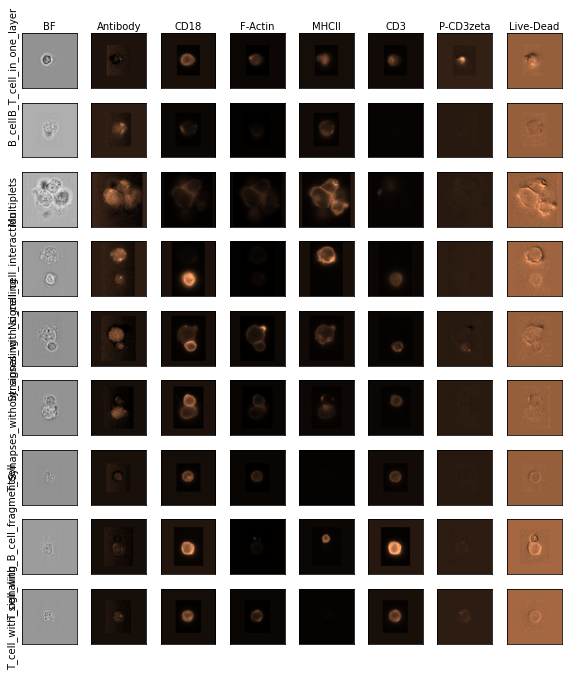

In [7]:
from skimage.util import crop
import h5py

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

def plot_images_with_metadata(metadata,  
                              figsize = None,
                              channels = ["BF","BF", "BF"],
                    channel_colors =  ["Greys", "Oranges", "Blues"],
                    image_size = 128):
    
    metadata_dummy = metadata.copy()
    metadata_dummy = metadata_dummy.reset_index(drop = True)
    
    nrows = len(metadata_dummy)
    ncols = len(channel_colors)
    
    if figsize is None:
        figsize = ( ncols*2, nrows*2 )
    fix,ax = plt.subplots(nrows, ncols, figsize = figsize, tight_layout = True)
    
    vmin = [4095.]*ncols
    vmax = [0.]*ncols
    
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]
        for j, ch in enumerate(range(ncols)):
            vmin[j] = min(vmin[j], image[:,:,ch].min()  )
            vmax[j] = max(vmax[j], image[:,:,ch].max()  )
        
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]         
        
        h, w = crop_pad_h_w(image, image_size)
        h1_crop, h2_crop, h1_pad, h2_pad =  h 
        w1_crop, w2_crop, w1_pad, w2_pad = w 
        for j, ch in enumerate(channel_colors):
            image_dummy = crop(image[:,:,j], ((h1_crop,h2_crop),(w1_crop,w2_crop)))            
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values = np.mean(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
            if j == 0:
                print(metadata_dummy.loc[i,"label"])
                ax[i,j].set_ylabel(metadata_dummy.loc[i,"label"])
            if i == 0:
                ax[i,j].set_xlabel(channels[j])
                ax[i,j].xaxis.set_label_position('top') 
            
        h5_file_.close()
    plt.tight_layout()

    
plot_images_with_metadata(metadata.groupby('label').apply(lambda s: s.sample(1, random_state = 3)).reset_index(drop = True) ,  
                              figsize = (8,len(metadata.label.unique())),
                          channels = ["BF","Antibody","CD18","F-Actin","MHCII","CD3","P-CD3zeta","Live-Dead"],
                    channel_colors =  ["Greys", "copper", "copper", "copper", "copper", "copper", "copper", "copper"],
                    image_size = 128)



plt.savefig("Dataset 2 - synapses.png", bbox_inches='tight')
plt.savefig("Dataset 2 - synapses.svg", bbox_inches='tight')

Set all random seeds to the specific value, so the results are more reproducable

In [8]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

Define all necessary parameters

In [9]:

model_dir = "models"
log_dir = "logs"
scaling_factor = 255.
reshape_size = 128
train_transform = [
         transforms.RandomVerticalFlip(),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(45)
        ]
test_transform = [ ]
num_classes = len(metadata.label.unique())

In [10]:

channels = np.asarray(["BF","Antibody","CD18","F-Actin","MHCII","CD3","P-CD3zeta","Live-Dead"])
selected_channels = np.arange(len(channels))
num_channels = len(selected_channels)
num_of_all_channels = len(channels)
all_channels = np.arange(num_of_all_channels)

In [11]:
selected_channels

array([0, 1, 2, 3, 4, 5, 6, 7])

In [12]:
batch_size = 128
num_workers = 4
device="cuda"

splitting data to train, validaiton and test

In [13]:
train_index =  metadata.set.isin(["train"])
train_index = train_index[train_index].index

validation_index =  metadata.set.isin(["validation"])
validation_index = validation_index[validation_index].index

test_index =  metadata.set.isin(["test"])
test_index = test_index[test_index].index

In [14]:
label_map = dict(zip(sorted(set(metadata.loc[train_index, "label"])), 
                     np.arange(len(set(metadata.loc[train_index, "label"])))))

set_of_interesting_classes = metadata.label.unique().tolist()

label_map

{'B_T_cell_in_one_layer': 0,
 'B_cell': 1,
 'Multiplets': 2,
 'No_cell_cell_interaction': 3,
 'Synapses_with_signaling': 4,
 'Synapses_without_signaling': 5,
 'T_cell': 6,
 'T_cell_with_B_cell_fragments': 7,
 'T_cell_with_signaling': 8}

now we calculate the statistics of every channel to later use for nomalizing the dataset

In [15]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose(train_transform))

In [16]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

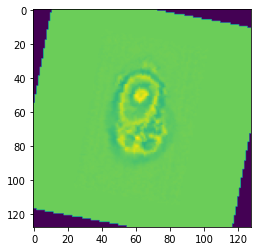

In [17]:
plt.imshow(train_dataset[0][0][0])

In [18]:
statistics = get_statistics(train_loader, selected_channels=selected_channels)

100%|██████████| 23/23 [01:54<00:00,  4.98s/it]

statistics used: {'min': tensor([0., 0., 0., 0., 0., 0., 0., 0.]), 'p01': tensor([0., 0., 0., 0., 0., 0., 0., 0.]), 'p05': tensor([0., 0., 0., 0., 0., 0., 0., 0.]), 'p25': tensor([3.1134, 0.0138, 0.1738, 0.1178, 0.1466, 0.2007, 0.1496, 0.1386]), 'p50': tensor([3.1325, 0.0237, 0.2373, 0.2282, 0.1644, 0.2514, 0.1536, 0.1412]), 'p75': tensor([3.1432, 0.0321, 0.3055, 0.3114, 0.2756, 0.3993, 0.1569, 0.1427]), 'p95': tensor([3.1773, 0.0504, 0.5315, 0.7550, 0.5959, 0.6385, 0.1644, 0.1503]), 'p99': tensor([3.3848, 0.1043, 1.0614, 1.6361, 1.3115, 1.6602, 0.1829, 0.1712]), 'max': tensor([ 5.4984,  0.9091,  5.3594, 12.6431,  7.2537,  5.5149,  1.9601,  1.0072]), 'mean': tensor([2.7662, 0.0246, 0.2558, 0.2820, 0.2386, 0.3202, 0.1368, 0.1255]), 'std': tensor([1.0089, 0.0197, 0.1918, 0.3740, 0.2523, 0.2847, 0.0517, 0.0468])}


adding the normalization to each transform

In [19]:
train_transform.append(transforms.Normalize(mean=statistics["mean"],
                         std=statistics["std"]))

test_transform.append(transforms.Normalize(mean=statistics["mean"],
                         std=statistics["std"]))

In [20]:
train_loader = None

defining train, validation and test datasets

In [21]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor, 
                                 reshape_size=reshape_size,
                                 transform= transforms.Compose(train_transform))

validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:],
                                      label_map=label_map,
                                      selected_channels=selected_channels,
                                      scaling_factor=scaling_factor,
                                      reshape_size=reshape_size,
                                      transform=transforms.Compose(test_transform))
test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                label_map=label_map,
                                selected_channels=selected_channels,
                                scaling_factor=scaling_factor,
                                reshape_size=reshape_size,
                                transform=
                                transforms.Compose(test_transform))

considering that we have multiple input channels, we need to modify the ResNet18 network input layer

In [22]:
import torch.nn as nn
from scifAI.dl.models import PretrainedModel
import torch.nn.functional as F

resnet18_modified = PretrainedModel(num_channels= len(channels),
                                     num_classes = len(set_of_interesting_classes), 
                                     pretrained = True)

In [23]:
resnet18_modified

PretrainedModel(
  (model): ResNet(
    (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1

finally, we add a scheduler and an early stopping based on valid_f1_macro

In [24]:
lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.1, patience=10)

epoch_scoring = EpochScoring("f1_macro", 
                             name =  "valid_f1_macro", 
                             on_train = False,
                             lower_is_better = False)

epoch_scoring = EpochScoring("f1_macro", 
                             name =  "valid_f1_macro", 
                             on_train = False,
                             lower_is_better = False)

early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                               patience=20, 
                               threshold=0.0001, 
                               threshold_mode='rel', 
                               lower_is_better=False)

lets define and train the model using `skorch`

In [25]:
net = NeuralNetClassifier(    
    resnet18_modified, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=batch_size,
    max_epochs=1000,
    optimizer=optim.AdamW,
    iterator_train__shuffle=True,
    iterator_train__num_workers=num_workers,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    callbacks=[lr_scheduler, epoch_scoring, early_stopping],
    train_split=predefined_split(validation_dataset),
    device="cuda",
    warm_start=True)

In [26]:
net = net.fit(train_dataset, y = None)

  epoch    train_loss    valid_acc    valid_f1_macro    valid_loss      dur
-------  ------------  -----------  ----------------  ------------  -------
      1        1.1008       0.5923            0.5276        1.7998  20.2140
      2        0.6355       0.6854            0.6156        0.9094  8.5774
      3        0.5429       0.7319            0.7137        0.8764  8.4815
      4        0.4512       0.7497            0.7294        0.6168  8.2797
      5        0.4338       0.7893            0.7809        0.6140  8.0937
      6        0.4169       0.6963            0.6864        0.8355  8.0621
      7        0.3713       0.7989            0.7969        0.5799  8.1519
      8        0.3227       0.7989            0.7816        0.5996  8.0165
      9        0.3561       0.8016            0.7988        0.5007  8.0928
     10        0.3162       0.8222            0.8134        0.5719  8.1114
     11        0.3153       0.7743            0.7403        0.6229  8.2207
     12        0.2906 

we stopped the training in 5 epochs. but you can let it train for longer time! :) 

lets take a look the prediction pefromance fore the validation set

In [27]:
inv_label_map = {v: k for k, v in label_map.items()}

preds = net.predict(validation_dataset)
preds =  [inv_label_map[int(t)] for t in preds]

classification_complete_report(validation_dataset.metadata.label, 
                               preds  )

                              precision    recall  f1-score   support

       B_T_cell_in_one_layer       0.88      0.80      0.84        74
                      B_cell       0.97      0.99      0.98        89
                  Multiplets       0.93      0.93      0.93        71
    No_cell_cell_interaction       0.90      0.94      0.92        82
     Synapses_with_signaling       0.87      0.94      0.90        94
  Synapses_without_signaling       0.83      0.78      0.81        69
                      T_cell       0.85      0.94      0.89        94
T_cell_with_B_cell_fragments       0.91      0.91      0.91        88
       T_cell_with_signaling       0.91      0.76      0.83        70

                    accuracy                           0.89       731
                   macro avg       0.89      0.89      0.89       731
                weighted avg       0.89      0.89      0.89       731

------------------------------------------------------------
matthews correlation coeff

and finally for the test set

In [28]:
preds = net.predict(test_dataset)
preds =  [inv_label_map[int(t)] for t in preds]

classification_complete_report(test_dataset.metadata.label, 
                               preds  )

                              precision    recall  f1-score   support

       B_T_cell_in_one_layer       0.90      0.83      0.86       161
                      B_cell       0.97      1.00      0.98       190
                  Multiplets       0.93      0.90      0.91       154
    No_cell_cell_interaction       0.97      0.93      0.95       182
     Synapses_with_signaling       0.85      0.89      0.87       196
  Synapses_without_signaling       0.79      0.86      0.83       147
                      T_cell       0.82      0.95      0.88       200
T_cell_with_B_cell_fragments       0.89      0.91      0.90       189
       T_cell_with_signaling       0.93      0.67      0.78       148

                    accuracy                           0.89      1567
                   macro avg       0.89      0.88      0.89      1567
                weighted avg       0.89      0.89      0.89      1567

------------------------------------------------------------
matthews correlation coeff

In [29]:
model = net.module_

### Model Interpretation

In [30]:
# where to save results
model_name = "resnet18"
dataset_name = "synapse formation"

#### Pixel-Permutation Tests

In [31]:
from time import process_time

In [32]:
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [33]:
correct = 0.
total = 0.
y_true = list()
y_pred = list()
y_true_proba = list()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).long()
        #Tracer()()
        outputs = model(inputs)
        pred = outputs.argmax(dim=1)
        true_proba = np.array([j[i] for (i,j) in zip(pred, outputs.cpu())])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels.reshape(-1) == predicted).sum().item()
        for i in range(len(pred)):
            y_true.append(labels[i].item())
            y_pred.append(pred[i].item())
            y_true_proba.append(true_proba[i].item())

In [34]:
class_names_targets = [c for c in label_map.keys()]

In [35]:
print(classification_report(y_true, y_pred, target_names=class_names_targets, digits=2))

                              precision    recall  f1-score   support

       B_T_cell_in_one_layer       0.90      0.83      0.86       161
                      B_cell       0.97      1.00      0.98       190
                  Multiplets       0.93      0.90      0.91       154
    No_cell_cell_interaction       0.97      0.93      0.95       182
     Synapses_with_signaling       0.85      0.89      0.87       196
  Synapses_without_signaling       0.79      0.86      0.83       147
                      T_cell       0.82      0.95      0.88       200
T_cell_with_B_cell_fragments       0.89      0.91      0.90       189
       T_cell_with_signaling       0.93      0.67      0.78       148

                    accuracy                           0.89      1567
                   macro avg       0.89      0.88      0.89      1567
                weighted avg       0.89      0.89      0.89      1567



100%|██████████| 100/100 [04:19<00:00,  2.60s/it]


Candidate channel  to remove is 0


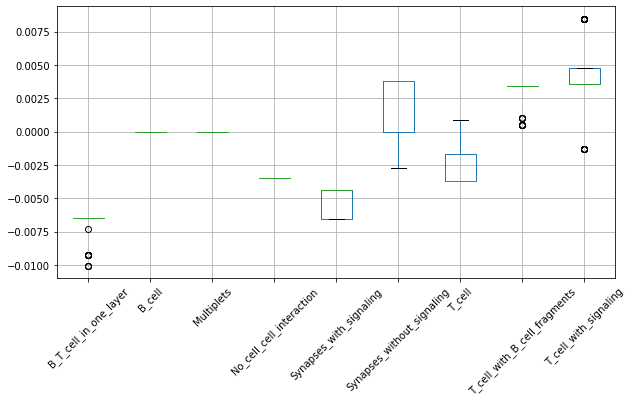

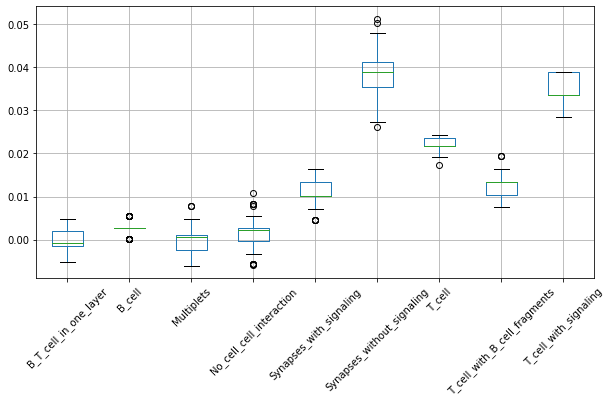

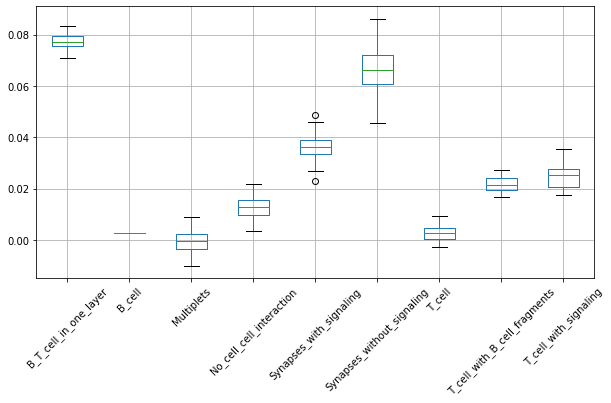

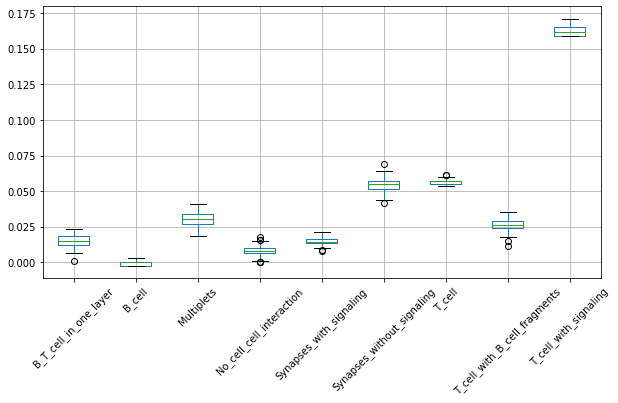

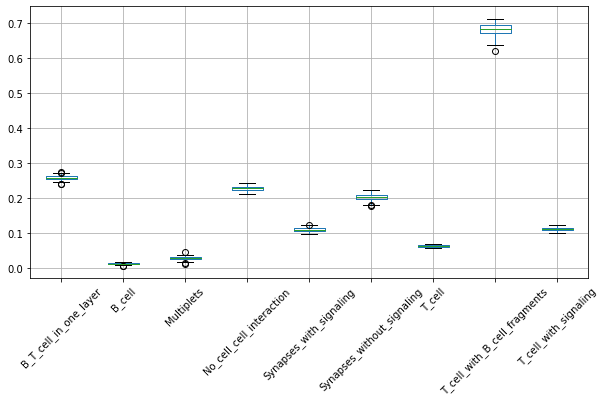

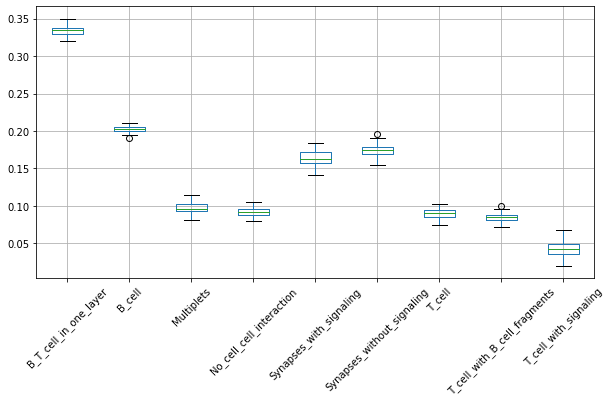

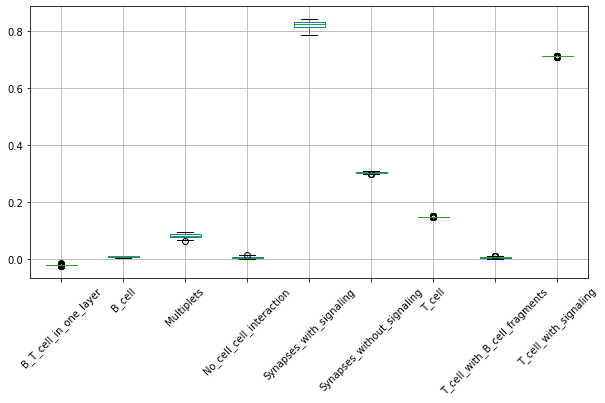

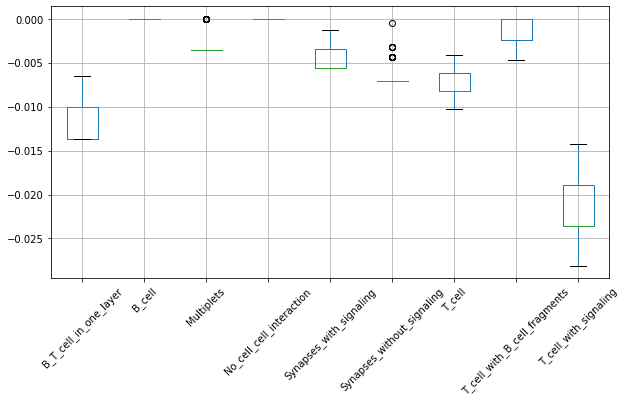

In [36]:
t1_start = process_time()
f1_score_original = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
min_mean_dif = 1.0
candidate = 0
shuffle_times = 100
df_all = pd.DataFrame([], columns=class_names_targets)
for c in range(num_channels):
    f1_score_diff_from_original_per_channel_per_shuffle = []
    transform = test_transform.copy()
    transform.append(ShuffleChannel(channels_to_shuffle=[c]))
    for s in tqdm(range(shuffle_times)):
        dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose(transform))
        dataloader = DataLoader(dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)
        y_true = list()
        y_pred = list()
        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
                outputs = model(inputs)
                pred = outputs.argmax(dim=1)
                for i in range(len(pred)):
                    y_true.append(labels[i].item())
                    y_pred.append(pred[i].item())
            f1_score_per_channel = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
            f1_score_diff_from_original_per_channel_per_shuffle.append(f1_score_original - f1_score_per_channel)
    mean_along_columns = np.mean(f1_score_diff_from_original_per_channel_per_shuffle, axis=0)
    mean_dif = np.mean(mean_along_columns)
    if mean_dif < min_mean_dif and mean_dif > 0 and not selected_channels[c]:
        min_mean_dif = mean_dif
        candidate = selected_channels[c]
    df_diff = pd.DataFrame(np.atleast_2d(f1_score_diff_from_original_per_channel_per_shuffle), columns=class_names_targets)
    df_mean_diff = pd.DataFrame(np.atleast_2d(mean_along_columns), columns=class_names_targets)
    df_all = pd.concat([df_all, df_mean_diff], ignore_index=True, sort=False)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = df_diff.boxplot()
    ax.set_xticklabels(class_names_targets, rotation=45)
    #fig.savefig(os.path.join("results",model_name, "{}-shuffle_method-model-{}-channel-{}.png".format(dataset_name, str(model_name), str(selected_channels[c]))))
print("Candidate channel  to remove is {}".format(candidate))

<BarContainer object of 8 artists>

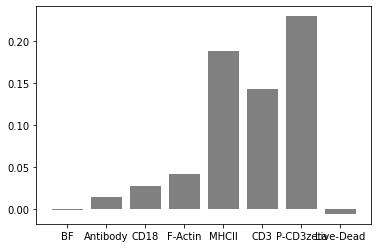

In [37]:
plt.bar(channels[selected_channels], df_all.T.mean(), color='Grey')
#plt.savefig(os.path.join("results",model_name, "{}-pixel-permutation-method-model-all-{}.svg".format(dataset_name, str("resnet_all"))))

In [38]:
channel_ranking_pixel_permutation = pd.DataFrame(data={'channels': channels[np.asarray(selected_channels)], 'importance': df_all.T.mean().to_numpy()})

In [39]:
from captum.attr import (
    GuidedGradCam,
    DeepLift,
    Saliency,
    DeepLiftShap,
    GradientShap,
    InputXGradient,
    IntegratedGradients,
    GuidedBackprop,
    Deconvolution,
    Occlusion,
    FeaturePermutation,
    ShapleyValueSampling,
    Lime,
    KernelShap,
    LRP
)
from time import process_time

In [40]:
def run_interpretation_method(ablator, method_name, require_baseline=False, require_sliding_window=False):
    t1_start = process_time()
    dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                     label_map=label_map,
                                     selected_channels=selected_channels,
                                     scaling_factor=scaling_factor,
                                     reshape_size=reshape_size,
                                     transform=transforms.Compose(test_transform))
    testloader = DataLoader(test_dataset,
                                    batch_size=batch_size,
                                    shuffle=False,
                                    num_workers=num_workers)

    heatmaps = torch.empty(0, dtype=torch.float32, device=device)
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
            if require_baseline:
                baselines=torch.zeros(inputs.shape).to(device)
                attr = ablator.attribute(inputs, target=labels, baselines=baselines)
            elif require_sliding_window:
                attr = ablator.attribute(inputs, target=labels, sliding_window_shapes=(1,3,3))
            else:
                attr = ablator.attribute(inputs, target=labels)
            heatmaps = torch.cat((heatmaps,  torch.from_numpy(np.percentile(torch.flatten(attr, start_dim=-2).cpu().numpy(), q=50, axis=-1)).to(device)))
    heatmaps_mean = torch.mean(heatmaps, dim=0)
    plt.bar(channels, heatmaps_mean.cpu(), color='grey')
    #plt.savefig(os.path.join("results", "resnet_all", "{}-{}_method-model-50-percentile-{}.png".format(dataset_name, method_name, str("resnet_all"))))

    t1_stop = process_time()
    print("Elapsed time:", t1_stop, t1_start) 

    print("Elapsed time during the whole program in seconds:",
                                             t1_stop-t1_start)
    return heatmaps_mean

In [41]:
# DeepLift

Elapsed time: 1419.578417377 1406.803057592
Elapsed time during the whole program in seconds: 12.775359785000092


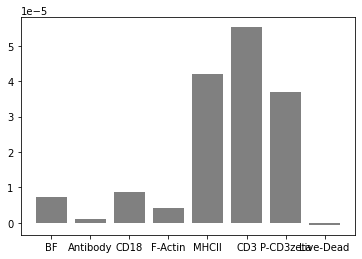

In [42]:
dl = DeepLift(model)
heatmaps_deeplift_mean = run_interpretation_method(dl, 'dl')

In [43]:
# Saliency

Elapsed time: 1431.114922222 1419.709190305
Elapsed time during the whole program in seconds: 11.405731916999912


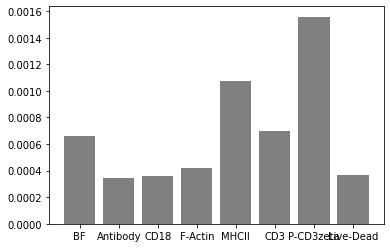

In [44]:
saliency = Saliency(model)
heatmaps_saliency_mean = run_interpretation_method(saliency, 'saliency')

In [45]:
# IntegratedGradients

In [46]:
ig = IntegratedGradients(model)
heatmaps_integrated_gradient_mean = run_interpretation_method(ig, 'IntegratedGradients')

RuntimeError: CUDA out of memory. Tried to allocate 6.25 GiB (GPU 0; 15.90 GiB total capacity; 9.62 GiB already allocated; 5.05 GiB free; 10.02 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# LRP

Elapsed time: 1444.005296284 1432.192385587
Elapsed time during the whole program in seconds: 11.812910697000007


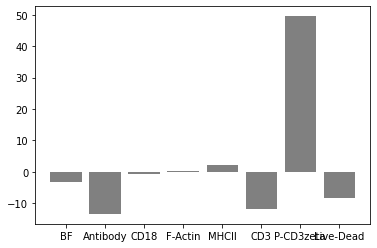

In [47]:
lrp = LRP(model)
heatmaps_lrp_mean = run_interpretation_method(lrp, 'LRP')

In [48]:
# GuidedGradCAM

Elapsed time: 1455.6628921 1444.141547369
Elapsed time during the whole program in seconds: 11.521344731


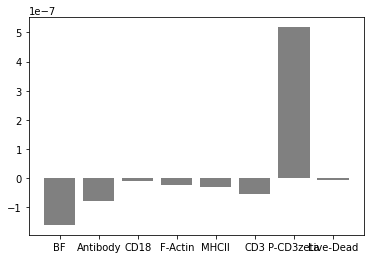

In [49]:
guided_cram = GuidedGradCam(model, model.model.layer1)
heatmaps_gradcam_mean = run_interpretation_method(guided_cram, 'GuidedGradCam')

5fold CV on the data and get the importance per fold for statistical evaluation
    
our result is in alignment with the original paper. On the other hand, guided gradcam failed